In [1]:
from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from numpy import linspace, loadtxt, ones, convolve
from sklearn.ensemble import IsolationForest
import numpy as np
import pandas as pd
import collections
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns
# style.use('fivethirtyeight')
%matplotlib inline

def evaluate(actual, predictions, output=True):
    mse = metrics.mean_squared_error(actual, predictions)
    rmse = math.sqrt(mse)

    if output:
        print('MSE:  {}'.format(mse))
        print('RMSE: {}'.format(rmse))
    else:
        return mse, rmse    

def plot_and_eval(predictions, actual, metric_fmt='{:.2f}', linewidth=4):
    if type(predictions) is not list:
        predictions = [predictions]

    plt.figure(figsize=(16, 8))
    plt.plot(df_ts_cohort,label='Train')
    plt.plot(df_ts_cohort, label='Test')

    for yhat in predictions:
        mse, rmse = evaluate(actual, yhat, output=False)        
        label = f'{yhat.name}'
        if len(predictions) > 1:
            label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.plot(yhat, label=label, linewidth=linewidth)

    if len(predictions) == 1:
        label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.title(label)

    plt.legend(loc='best')
    plt.show()    


# Detect Discrete Anomalies

In [2]:
colnames=['ip', 'timestamp', 'request_method', 'status', 'size',
          'destination', 'request_agent']
df_orig = pd.read_csv('http://python.zach.lol/access.log',          
                 engine='python',
                 header=None,
                 index_col=False,
                 names=colnames,
                 sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                 na_values='"-"',
                 usecols=[0, 3, 4, 5, 6, 7, 8]
)

new = pd.DataFrame([["95.31.18.119", "[21/Apr/2019:10:02:41+0000]", 
                     "GET /api/v1/items/HTTP/1.1", 200, 1153005, np.nan, 
                     "python-requests/2.21.0"],
                    ["95.31.16.121", "[17/Apr/2019:19:36:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 1005, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.15.120", "[18/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 2560, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.19.58", "[19/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 200, 2056327, np.nan, 
                     "python-requests/2.21.0"]], columns=colnames)

df = df_orig.append(new)

In [3]:
df.head()

,ip,timestamp,request_method,status,size,destination,request_agent
0,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
1,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""
2,97.105.19.58,[16/Apr/2019:19:34:44 +0000],"""GET /api/v1/sales?page=82 HTTP/1.1""",200,510103,NaN,"""python-requests/2.21.0"""
3,97.105.19.58,[16/Apr/2019:19:34:46 +0000],"""GET /api/v1/sales?page=83 HTTP/1.1""",200,510003,NaN,"""python-requests/2.21.0"""
4,97.105.19.58,[16/Apr/2019:19:34:48 +0000],"""GET /api/v1/sales?page=84 HTTP/1.1""",200,511963,NaN,"""python-requests/2.21.0"""


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13978 entries, 0 to 3
Data columns (total 7 columns):
ip                13978 non-null object
timestamp         13978 non-null object
request_method    13978 non-null object
status            13978 non-null int64
size              13978 non-null int64
destination       25 non-null object
request_agent     13978 non-null object
dtypes: int64(2), object(5)
memory usage: 873.6+ KB


In [5]:
df.timestamp = df.timestamp.str.replace(r'(\[|\])', '', regex=True) # replace the brackets with empty string
df.timestamp= pd.to_datetime(df.timestamp.str.replace(':', ' ', 1)) # replace the first instance of this
df = df.set_index('timestamp')

In [6]:
for col in ['request_method', 'request_agent', 'destination']:
    df[col] = df[col].str.replace('"', '') # replace quotes with nothing

# replace the question mark and the page plus page numbers
df['request_method'] = df.request_method.str.replace(r'\?page=[0-9]+', '', regex=True)

df.head()

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,NaN,python-requests/2.21.0
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,NaN,python-requests/2.21.0
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,NaN,python-requests/2.21.0
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,NaN,python-requests/2.21.0


In [7]:
df['size_mb'] = [n/1024/1024 for n in df['size']] #normalizes the size column?

In [8]:
df.describe()

,status,size,size_mb
count,13978.000000,1.397800e+04,13978.000000
mean,200.356703,4.500019e+05,0.429155
std,10.182001,1.614915e+05,0.154010
min,200.000000,0.000000e+00,0.000000
25%,200.000000,5.006370e+05,0.477445
50%,200.000000,5.101380e+05,0.486506
75%,200.000000,5.112910e+05,0.487605
max,499.000000,2.056327e+06,1.961066


In [9]:
ip_df = pd.DataFrame(df.ip.value_counts(dropna=False)).reset_index().\
                rename(index=str, columns={'index': 'ip', 'ip': 'ip_count'})
ip_df2 = pd.DataFrame(df.ip.value_counts(dropna=False)/df.ip.count()).reset_index().\
                rename(index=str, columns={'index': 'ip', 'ip': 'ip_proba'})
ip_df = ip_df.merge(ip_df2)


# see those where rate < 1%
ip_df[ip_df.ip_proba < .01]

,ip,ip_count,ip_proba
4,24.26.242.9,21,0.001502
5,68.201.219.223,21,0.001502
6,70.121.214.34,2,0.000143
7,35.175.171.137,2,0.000143
8,52.87.230.102,2,0.000143
9,54.145.52.184,1,0.000072
10,34.207.64.242,1,0.000072
11,34.229.70.250,1,0.000072
12,3.88.129.158,1,0.000072
13,97.105.15.120,1,0.000072


22
               ip  ip_count  ip_proba
12   3.88.129.158         1  0.000072
13  97.105.15.120         1  0.000072
14   95.31.18.119         1  0.000072
15   52.91.30.150         1  0.000072
16   35.174.209.2         1  0.000072
17   45.23.250.16         1  0.000072
18   95.31.16.121         1  0.000072
19  52.90.165.200         1  0.000072
20  54.172.14.223         1  0.000072
21   3.92.201.136         1  0.000072


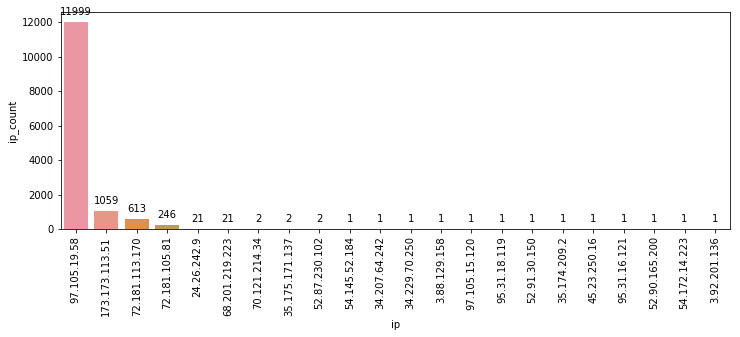

In [10]:
print(len(ip_df))

print(ip_df.tail(10))

plt.figure(figsize=(12, 4))
splot = sns.barplot(data=ip_df, x = 'ip', y = 'ip_count', ci = None)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 10), 
                   textcoords = 'offset points'
                   )
    plt.xticks(rotation='vertical')

## Detecting anomalies by establishing a baseline and evaluate as new data arrives

In [11]:
# Establish baseline
train = df['2019-04-16 19:34:42':'2019-04-17 12:55:14'][['ip','request_method', 'status', 'size', 'destination', 'request_agent', 'size_mb']]


In [12]:
# Compute probabilities based on train sample
ip_df = pd.DataFrame(train.ip.value_counts(dropna=False)/train.ip.count()).reset_index().\
                rename(index=str, columns={'index':'ip', 'ip': 'ip_proba'})

In [13]:
# Merge probabilities with all data (train+new data)
# Where the ip address is new, i.e. not seen in the training dataset,
# fill the probability with a value of 0.
df = df.reset_index().merge(ip_df, on=['ip'], how='left').fillna(value=0).set_index('timestamp')

df.ip_proba.value_counts()

0.858595    11999
0.075784     1059
0.043867      613
0.017604      246
0.001503       42
0.000072       10
0.000143        6
0.000000        3
Name: ip_proba, dtype: int64

## Conditional Probabilities: probabilities using 2 discrete variables

In [14]:
#probabilities of Status given ip Address
# If we are looking for an unexpected status (like authentication failure) from a known/common ip address.

ip_probs = train.groupby('ip').size().div(len(df))

status_given_ip = pd.DataFrame(train.groupby(['ip', 'status']).\
                               size().div(len(train)).\
                               div(ip_probs, 
                                   axis=0, 
                                   level='ip').\
                               reset_index().\
                               rename(index=str, 
                                      columns={0: 'proba_status_given_ip'})
                              )

In [15]:
ip_status_count = pd.DataFrame(train.groupby(['ip', 'status'])['request_agent'].\
                                count().reset_index().\
                                rename(index=str, 
                                       columns={'request_agent': 'ip_status_count'}))


ip_status = status_given_ip.merge(ip_status_count)

In [16]:
# Add thes probabilities to original events to detect anomalous events

df = df.reset_index().merge(ip_status, on=['ip','status'],how='left').fillna(value=0).set_index('timestamp')

In [17]:
df.head()

,ip,request_method,status,size,destination,request_agent,size_mb,ip_proba,proba_status_given_ip,ip_status_count
timestamp,,,,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,0,python-requests/2.21.0,0.488753,0.858595,0.999119,11984.0
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,0,python-requests/2.21.0,0.003396,0.858595,0.999119,11984.0
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,0,python-requests/2.21.0,0.486472,0.858595,0.999119,11984.0
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,0,python-requests/2.21.0,0.486377,0.858595,0.999119,11984.0
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,0,python-requests/2.21.0,0.488246,0.858595,0.999119,11984.0


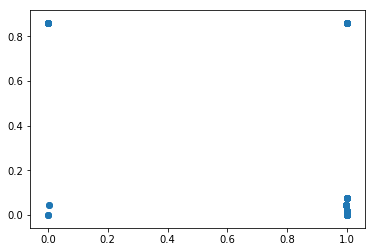

In [18]:
plt.scatter(df.proba_status_given_ip, df.ip_proba)

# Detect Time Series Anomalies

In [19]:
data = pd.read_csv('anonymized-curriculum-access.txt', sep=" ", header=None)
# data.columns = ["a", "b", "c", 'd', "etc."]

In [20]:
data.head(100)

,0,1,2,3,4,5
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61
5,2018-01-26,09:56:41,javascript-i/loops,2,22.0,97.105.19.61
6,2018-01-26,09:56:46,javascript-i/conditionals,3,22.0,97.105.19.61
7,2018-01-26,09:56:48,javascript-i/functions,3,22.0,97.105.19.61
8,2018-01-26,09:56:59,javascript-i/loops,2,22.0,97.105.19.61
9,2018-01-26,09:58:26,javascript-i/functions,4,22.0,97.105.19.61


In [21]:
data['date'] = data[0].map(str) + ' ' + data[1]

In [22]:
data.head()

,0,1,2,3,4,5,date
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61,2018-01-26 09:55:03
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61,2018-01-26 09:56:02
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,2018-01-26 09:56:05
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,2018-01-26 09:56:06
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,2018-01-26 09:56:24


In [23]:
type(data.date)

pandas.core.series.Series

In [24]:
data['date'] = pd.to_datetime(data.date)

In [25]:
data.head()

,0,1,2,3,4,5,date
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61,2018-01-26 09:55:03
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61,2018-01-26 09:56:02
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,2018-01-26 09:56:05
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,2018-01-26 09:56:06
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,2018-01-26 09:56:24


In [26]:
data.dtypes

0               object
1               object
2               object
3                int64
4              float64
5               object
date    datetime64[ns]
dtype: object

In [27]:
data.set_index(data.date, inplace=True)

In [28]:
data.head(20)

,0,1,2,3,4,5,date
date,,,,,,,
2018-01-26 09:55:03,2018-01-26,09:55:03,/,1,8.0,97.105.19.61,2018-01-26 09:55:03
2018-01-26 09:56:02,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61,2018-01-26 09:56:02
2018-01-26 09:56:05,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,2018-01-26 09:56:05
2018-01-26 09:56:06,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,2018-01-26 09:56:06
2018-01-26 09:56:24,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,2018-01-26 09:56:24
2018-01-26 09:56:41,2018-01-26,09:56:41,javascript-i/loops,2,22.0,97.105.19.61,2018-01-26 09:56:41
2018-01-26 09:56:46,2018-01-26,09:56:46,javascript-i/conditionals,3,22.0,97.105.19.61,2018-01-26 09:56:46
2018-01-26 09:56:48,2018-01-26,09:56:48,javascript-i/functions,3,22.0,97.105.19.61,2018-01-26 09:56:48
2018-01-26 09:56:59,2018-01-26,09:56:59,javascript-i/loops,2,22.0,97.105.19.61,2018-01-26 09:56:59


In [29]:
data.columns

Index([0, 1, 2, 3, 4, 5, 'date'], dtype='object')

In [30]:
data = data.rename(columns={0: 'time1', 1: "time2", 2: 'link', 3: 'number1', 4: 'number2', 5: 'ip'})

In [31]:
data.head()

,time1,time2,link,number1,number2,ip,date
date,,,,,,,
2018-01-26 09:55:03,2018-01-26,09:55:03,/,1,8.0,97.105.19.61,2018-01-26 09:55:03
2018-01-26 09:56:02,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61,2018-01-26 09:56:02
2018-01-26 09:56:05,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,2018-01-26 09:56:05
2018-01-26 09:56:06,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,2018-01-26 09:56:06
2018-01-26 09:56:24,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,2018-01-26 09:56:24


In [32]:
data = data.drop(['time1', 'time2'], axis=1)

In [33]:
data.head()

,link,number1,number2,ip,date
date,,,,,
2018-01-26 09:55:03,/,1,8.0,97.105.19.61,2018-01-26 09:55:03
2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61,2018-01-26 09:56:02
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,2018-01-26 09:56:05
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,2018-01-26 09:56:06
2018-01-26 09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,2018-01-26 09:56:24


In [34]:
data = data.drop(['date'], axis=1)

In [35]:
data.head()

,link,number1,number2,ip
date,,,,
2018-01-26 09:55:03,/,1,8.0,97.105.19.61
2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
2018-01-26 09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61


In [36]:
data = data.rename(columns={'number2': 'cohort', 'number1':'user_id'})

In [37]:
data.head()

,link,user_id,cohort,ip
date,,,,
2018-01-26 09:55:03,/,1,8.0,97.105.19.61
2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
2018-01-26 09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61


In [38]:
data.isnull().sum()

link           0
user_id        0
cohort     14458
ip             0
dtype: int64

In [39]:
data.cohort.fillna(0, inplace=True)

In [40]:
data.isnull().sum()

link       0
user_id    0
cohort     0
ip         0
dtype: int64

In [41]:
df1 = data.where(data.cohort == 0)

In [42]:
df1 = df1.dropna()

In [43]:
df1.head()

,link,user_id,cohort,ip
date,,,,
2018-01-26 16:46:16,/,48.0,0.0,97.105.19.61
2018-01-26 16:46:24,spring/extra-features/form-validation,48.0,0.0,97.105.19.61
2018-01-26 17:54:24,/,48.0,0.0,97.105.19.61
2018-01-26 18:32:03,/,48.0,0.0,97.105.19.61
2018-01-26 18:32:17,mysql/relationships/joins,48.0,0.0,97.105.19.61


In [44]:
my_datetime_fmt = mdates.DateFormatter('%m-%d %H:%T')

df_ts_cohort = df1['cohort'].resample('W').count()

idx = pd.date_range(
    df_ts_cohort.sort_index().index.min(), 
    df_ts_cohort.sort_index().index.max(),
    freq='W'
)

df_ts_cohort = df_ts_cohort.reindex(idx, fill_value=0).fillna(value=0)



In [45]:
short_rolling = df_ts_cohort.rolling(window=12).mean()

In [46]:
long_rolling = df_ts_cohort.rolling(window=24).mean()

Text(0, 0.5, '# of Staff Views')

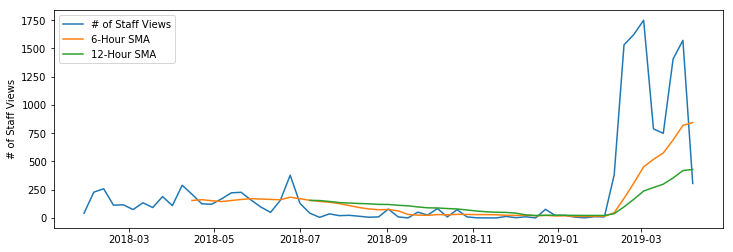

In [47]:
fig, ax = plt.subplots(figsize=(12,4))

ax.plot(df_ts_cohort.index, 
        df_ts_cohort,
        label='# of Staff Views')

ax.plot(short_rolling.index, 
        short_rolling, 
        label = '6-Hour SMA')
ax.plot(long_rolling.index, 
        long_rolling, 
        label = '12-Hour SMA')

ax.legend(loc='best')
ax.set_ylabel('# of Staff Views')
# ax.xaxis.(rotate=90)
# ax.xaxis.set_major_formatter(my_datetime_fmt)

In [48]:
# Exponential Moving Average

In [49]:
ema_short = df_ts_cohort.ewm(span=12, adjust=False).mean()
ema_short[0:3]

ema_long = df_ts_cohort.ewm(span=24, adjust=False).mean()
ema_long[0:3]

2018-01-28    41.0000
2018-02-04    55.9600
2018-02-11    72.1232
Freq: W-SUN, Name: cohort, dtype: float64

In [50]:
span = 24
ema_long = df_ts_cohort.ewm(span=span, adjust=False).mean()
midband = ema_long[-1]
ub = midband + ema_long[-24:-1].std()*3
lb = midband - ema_long[-24:-1].std()*3

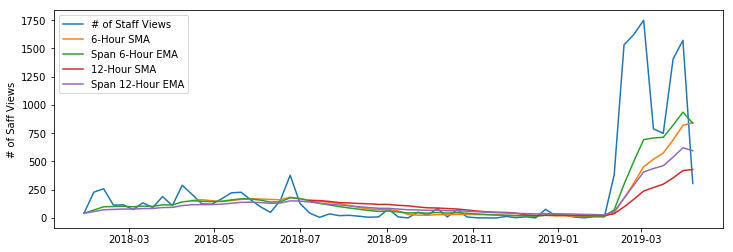

In [51]:
fig, ax = plt.subplots(figsize=(12,4))

ax.plot(df_ts_cohort.index, 
        df_ts_cohort,
        label='# of Staff Views')

ax.plot(short_rolling.index, 
        short_rolling, 
        label = '6-Hour SMA')
ax.plot(long_rolling.index, 
        ema_short, 
        label = 'Span 6-Hour EMA')
ax.plot(long_rolling.index, 
        long_rolling, 
        label = '12-Hour SMA')
ax.plot(long_rolling.index, 
        ema_long, 
        label = 'Span 12-Hour EMA')

ax.legend(loc='best')
ax.set_ylabel('# of Saff Views')

yhat = pd.DataFrame(dict(actual=df_ts_cohort))

In [52]:
span = 24
ema_long = df_ts_cohort.ewm(span=span, adjust=False).mean()
midband = ema_long[-1]
ub = midband + ema_long[-24:-1].std()*3
lb = midband - ema_long[-24:-1].std()*3

yhat['moving_avg_forecast'] = midband

In [53]:
# compute the %%b for each record

In [54]:
yhat['error'] = abs(yhat.actual - yhat.moving_avg_forecast)

In [55]:
yhat['pct_b'] = (yhat.actual-lb)/(ub-lb)

In [56]:
# Extract the anomalies

In [57]:
yhat[yhat.pct_b > 1]

,actual,moving_avg_forecast,error,pct_b
2019-02-17,1532,595.37489,936.62511,1.304553
2019-02-24,1624,595.37489,1028.62511,1.383581
2019-03-03,1750,595.37489,1154.62511,1.491814
2019-03-24,1407,595.37489,811.62511,1.197179
2019-03-31,1572,595.37489,976.62511,1.338913


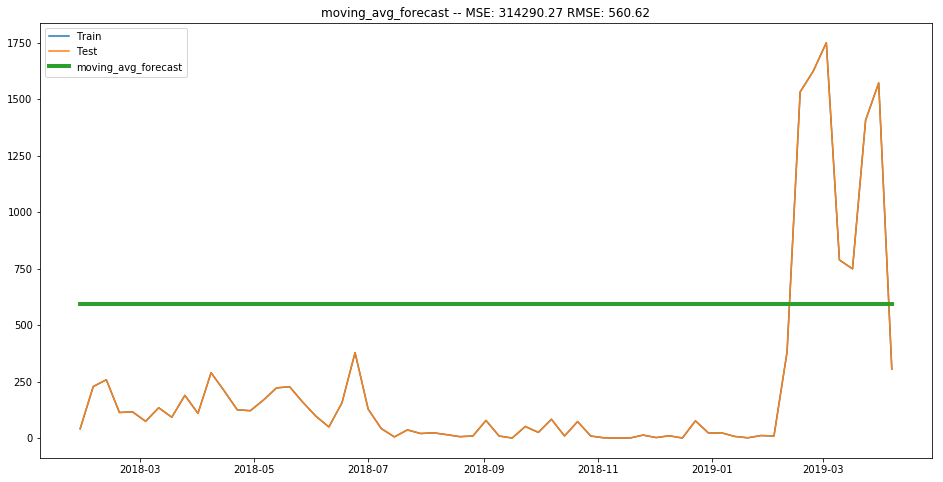

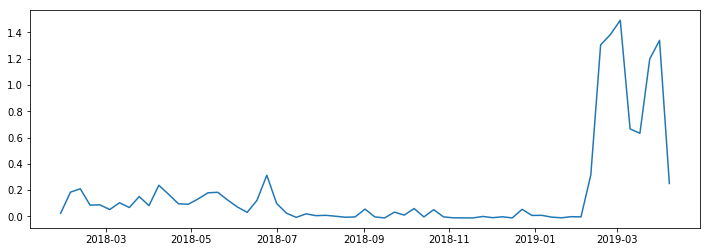

In [58]:
plot_and_eval(yhat.moving_avg_forecast, actual=df_ts_cohort)
plt.figure(figsize=(12,4))
plt.plot(yhat.pct_b)

# Detecting anomalies using TS - another way

In [59]:
df = pd.read_csv('cohort_names.csv')

In [60]:
df.head()

,id,name,start_date,end_date
0,1,Arches,2/4/14,4/22/14
1,2,Badlands,6/4/14,8/22/14
2,3,Carlsbad,9/4/14,11/5/14
3,4,Denali,10/20/14,1/18/15
4,5,Everglades,11/18/14,2/24/15


In [61]:
df = df.drop(['start_date', 'end_date'], axis=1)

In [62]:
df1 = pd.read_csv('anonymized-curriculum-access.txt', sep=" ", header=None)

In [63]:
df1.head()

,0,1,2,3,4,5
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61


In [64]:
df1 = df1.dropna()

In [65]:
df1.rename({0:'date', 1:'time', 2:'link',3:'user_id', 4:'id',5:'ip'},axis=1, inplace=True)

In [66]:
df1.head()

,date,time,link,user_id,id,ip
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61


In [67]:
df1 = df1.drop(['time'], axis=1)

In [68]:
df1 = df1.dropna()
df1.id = df1.id.astype('int')
print(df1.info())
df1.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 219070 entries, 0 to 233527
Data columns (total 5 columns):
date       219070 non-null object
link       219070 non-null object
user_id    219070 non-null int64
id         219070 non-null int64
ip         219070 non-null object
dtypes: int64(2), object(3)
memory usage: 10.0+ MB
None


,date,link,user_id,id,ip
0,2018-01-26,/,1,8,97.105.19.61
1,2018-01-26,java-ii,1,8,97.105.19.61
2,2018-01-26,java-ii/object-oriented-programming,1,8,97.105.19.61
3,2018-01-26,slides/object_oriented_programming,1,8,97.105.19.61
4,2018-01-26,javascript-i/conditionals,2,22,97.105.19.61


In [69]:
df = df1.merge(df, on='id', how='left')

In [70]:
df.head()

,date,link,user_id,id,ip,name
0,2018-01-26,/,1,8,97.105.19.61,Hampton
1,2018-01-26,java-ii,1,8,97.105.19.61,Hampton
2,2018-01-26,java-ii/object-oriented-programming,1,8,97.105.19.61,Hampton
3,2018-01-26,slides/object_oriented_programming,1,8,97.105.19.61,Hampton
4,2018-01-26,javascript-i/conditionals,2,22,97.105.19.61,Teddy


In [71]:
df['date'] = pd.to_datetime(df.date)

In [72]:
df = df.dropna()

In [73]:
df.dtypes

date       datetime64[ns]
link               object
user_id             int64
id                  int64
ip                 object
name               object
dtype: object

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 219070 entries, 0 to 219069
Data columns (total 6 columns):
date       219070 non-null datetime64[ns]
link       219070 non-null object
user_id    219070 non-null int64
id         219070 non-null int64
ip         219070 non-null object
name       219070 non-null object
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 11.7+ MB


In [75]:
df.head()

,date,link,user_id,id,ip,name
0,2018-01-26,/,1,8,97.105.19.61,Hampton
1,2018-01-26,java-ii,1,8,97.105.19.61,Hampton
2,2018-01-26,java-ii/object-oriented-programming,1,8,97.105.19.61,Hampton
3,2018-01-26,slides/object_oriented_programming,1,8,97.105.19.61,Hampton
4,2018-01-26,javascript-i/conditionals,2,22,97.105.19.61,Teddy


In [76]:
df = df.drop(['link'], axis=1)

In [77]:
df.head()

,date,user_id,id,ip,name
0,2018-01-26,1,8,97.105.19.61,Hampton
1,2018-01-26,1,8,97.105.19.61,Hampton
2,2018-01-26,1,8,97.105.19.61,Hampton
3,2018-01-26,1,8,97.105.19.61,Hampton
4,2018-01-26,2,22,97.105.19.61,Teddy


In [78]:
df_agg = df.groupby(['date', 'id', 'name'])['user_id'].\
                        nunique().\
                    reset_index().\
                    rename(index=str,
                          columns={'user_id':'users_viewed'})

In [79]:
df_agg.head()

,date,id,name,users_viewed
0,2018-01-26,1,Arches,1
1,2018-01-26,8,Hampton,1
2,2018-01-26,13,Kings,1
3,2018-01-26,16,Niagara,2
4,2018-01-26,18,Pinnacles,1


## EMA

In [80]:
cohorts = list(df_agg.name.unique())
cohorts

['Arches',
 'Hampton',
 'Kings',
 'Niagara',
 'Pinnacles',
 'Quincy',
 'Sequoia',
 'Teddy',
 'Lassen',
 'Mammoth',
 'Glacier',
 'Denali',
 'Joshua',
 'Olympic',
 'Ulysses',
 'Badlands',
 'Apollo',
 'Ike',
 'Voyageurs',
 'Wrangell',
 'Xanadu',
 'Franklin',
 'Yosemite',
 'Staff',
 'Zion',
 'Andromeda']

In [81]:
df_agg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3366 entries, 0 to 3365
Data columns (total 4 columns):
date            3366 non-null datetime64[ns]
id              3366 non-null int64
name            3366 non-null object
users_viewed    3366 non-null int64
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 131.5+ KB


In [82]:
df = df_agg.set_index('date').\
            rename(index=str, columns={'users_viewed':'ema'}).\
            drop(columns='id')

In [83]:
def bollinger_bands(df):
    ema = df.ewm(span=14, adjust=False).mean()
    ema['stdev'] = ema.ema.rolling(14).std()
    ema['ub'] = ema.ema + ema.stdev*3
    ema['lb'] = ema.ema - ema.stdev*3
    return ema.reset_index()

In [84]:
# bollinger_bands(df_agg[df_agg.cohort_id==8])
bands = []
for cohort in cohorts:
    bb = bollinger_bands(df[df.name == cohort])
    bands.append(bb)

df2 = pd.concat(bands)

In [85]:
df2.head()

,date,name,ema,stdev,ub,lb
0,2018-01-26 00:00:00,Arches,1.000000,NaN,NaN,NaN
1,2018-01-29 00:00:00,Arches,1.266667,NaN,NaN,NaN
2,2018-01-30 00:00:00,Arches,1.364444,NaN,NaN,NaN
3,2018-01-31 00:00:00,Arches,1.449185,NaN,NaN,NaN
4,2018-02-01 00:00:00,Arches,1.389294,NaN,NaN,NaN


In [86]:
df2.isnull().sum()

date       0
name       0
ema        0
stdev    298
ub       298
lb       298
dtype: int64

In [87]:
df_missing = df2[df2.stdev.isnull()][['name', 'ema']]
df_missing.head()

,name,ema
0,Arches,1.000000
1,Arches,1.266667
2,Arches,1.364444
3,Arches,1.449185
4,Arches,1.389294


In [88]:
df_missing = df_missing.groupby('name').std().fillna(value=0).reset_index().rename(index=str, columns={'ema':'stdev_null'})
df_missing.head()




,name,stdev_null
0,Andromeda,3.418950
1,Apollo,0.000000
2,Arches,0.212673
3,Badlands,0.000000
4,Denali,0.000000


In [89]:
df = df2.merge(df_missing, on='name', how='left')

In [90]:
df.head()

,date,name,ema,stdev,ub,lb,stdev_null
0,2018-01-26 00:00:00,Arches,1.000000,NaN,NaN,NaN,0.212673
1,2018-01-29 00:00:00,Arches,1.266667,NaN,NaN,NaN,0.212673
2,2018-01-30 00:00:00,Arches,1.364444,NaN,NaN,NaN,0.212673
3,2018-01-31 00:00:00,Arches,1.449185,NaN,NaN,NaN,0.212673
4,2018-02-01 00:00:00,Arches,1.389294,NaN,NaN,NaN,0.212673


In [91]:
idx = df.stdev.isnull()
df.loc[idx,'stdev'] = df.loc[idx,'stdev_null']

df = df.drop(columns = 'stdev_null')
df.head()

,date,name,ema,stdev,ub,lb
0,2018-01-26 00:00:00,Arches,1.000000,0.212673,NaN,NaN
1,2018-01-29 00:00:00,Arches,1.266667,0.212673,NaN,NaN
2,2018-01-30 00:00:00,Arches,1.364444,0.212673,NaN,NaN
3,2018-01-31 00:00:00,Arches,1.449185,0.212673,NaN,NaN
4,2018-02-01 00:00:00,Arches,1.389294,0.212673,NaN,NaN


In [92]:
idx = df.ub.isnull()
df.loc[idx,'ub'] = df.loc[idx,'ema'] + df.loc[idx,'stdev']*3
df.loc[idx,'lb'] = df.loc[idx,'ema'] - df.loc[idx,'stdev']*3

df.head()

,date,name,ema,stdev,ub,lb
0,2018-01-26 00:00:00,Arches,1.000000,0.212673,1.638018,0.361982
1,2018-01-29 00:00:00,Arches,1.266667,0.212673,1.904685,0.628648
2,2018-01-30 00:00:00,Arches,1.364444,0.212673,2.002463,0.726426
3,2018-01-31 00:00:00,Arches,1.449185,0.212673,2.087204,0.811167
4,2018-02-01 00:00:00,Arches,1.389294,0.212673,2.027312,0.751275


In [93]:
idx = df.ub == df.lb
df.loc[idx,'ub'] = df.loc[idx, 'ub'] + .01
df.loc[idx,'lb'] = df.loc[idx, 'lb'] - .01

In [94]:
df.date = pd.to_datetime(df.date)

In [95]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3366 entries, 0 to 3365
Data columns (total 6 columns):
date     3366 non-null datetime64[ns]
name     3366 non-null object
ema      3366 non-null float64
stdev    3366 non-null float64
ub       3366 non-null float64
lb       3366 non-null float64
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 184.1+ KB


In [96]:
df_agg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3366 entries, 0 to 3365
Data columns (total 4 columns):
date            3366 non-null datetime64[ns]
id              3366 non-null int64
name            3366 non-null object
users_viewed    3366 non-null int64
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 131.5+ KB


In [97]:
# join with aggregated dataset to get the original count of users viewed
df = df.merge(df_agg, on=['name', 'date'], how='left')
df.head()


,date,name,ema,stdev,ub,lb,id,users_viewed
0,2018-01-26,Arches,1.000000,0.212673,1.638018,0.361982,1,1
1,2018-01-29,Arches,1.266667,0.212673,1.904685,0.628648,1,3
2,2018-01-30,Arches,1.364444,0.212673,2.002463,0.726426,1,2
3,2018-01-31,Arches,1.449185,0.212673,2.087204,0.811167,1,2
4,2018-02-01,Arches,1.389294,0.212673,2.027312,0.751275,1,1


In [98]:
# Computer %b
df['pct_b'] = (df.users_viewed - df.lb)/ (df.ub - df.lb)
df = df.drop(columns=['stdev', 'id'])
df.head()

,date,name,ema,ub,lb,users_viewed,pct_b
0,2018-01-26,Arches,1.000000,1.638018,0.361982,1,0.500000
1,2018-01-29,Arches,1.266667,1.904685,0.628648,3,1.858372
2,2018-01-30,Arches,1.364444,2.002463,0.726426,2,0.998070
3,2018-01-31,Arches,1.449185,2.087204,0.811167,2,0.931661
4,2018-02-01,Arches,1.389294,2.027312,0.751275,1,0.194920


In [99]:
df[df.pct_b>1].sort_values(by='pct_b', ascending = False).head()

,date,name,ema,ub,lb,users_viewed,pct_b
2286,2018-11-05,Ulysses,1.909928,2.261775,1.558080,5,4.891207
938,2018-07-11,Quincy,1.140681,1.241638,1.039724,2,4.755855
1799,2018-11-07,Lassen,1.138224,1.239632,1.036816,2,4.749037
1730,2018-08-20,Lassen,1.137121,1.239248,1.034993,2,4.724532
595,2018-11-19,Kings,1.284884,1.488118,1.081650,3,4.719563


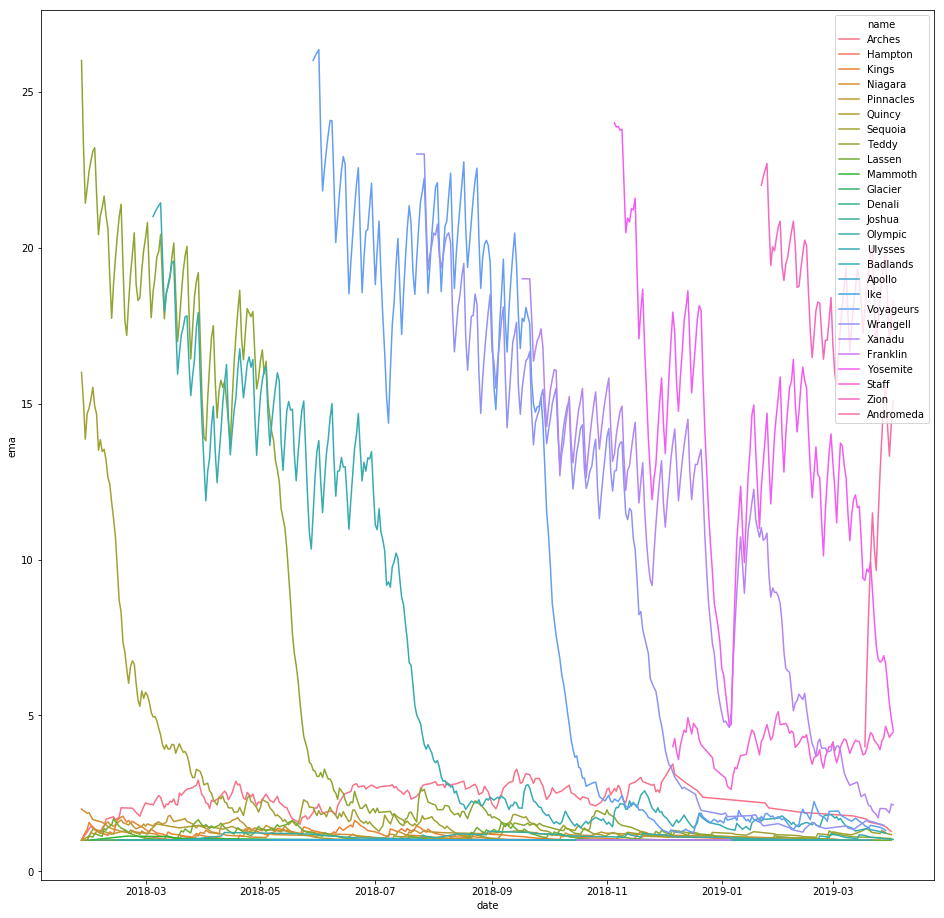

In [100]:
# plot the 7 day exponential moving average
fig = plt.figure(figsize=(16,16))
sns.lineplot(df.date, df.ema, hue=df.name)

# Clustering - DBSCAN

In [101]:
from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [102]:
df = pd.read_csv('customers.csv')

In [103]:
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [104]:
df.drop(['Channel', 'Region'], axis=1, inplace = True)

In [105]:
df.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185


In [106]:
np_array = df.values.astype('float32', copy = False)

In [107]:
np_array[0:10]

array([[12669.,  9656.,  7561.,   214.,  2674.,  1338.],
       [ 7057.,  9810.,  9568.,  1762.,  3293.,  1776.],
       [ 6353.,  8808.,  7684.,  2405.,  3516.,  7844.],
       [13265.,  1196.,  4221.,  6404.,   507.,  1788.],
       [22615.,  5410.,  7198.,  3915.,  1777.,  5185.],
       [ 9413.,  8259.,  5126.,   666.,  1795.,  1451.],
       [12126.,  3199.,  6975.,   480.,  3140.,   545.],
       [ 7579.,  4956.,  9426.,  1669.,  3321.,  2566.],
       [ 5963.,  3648.,  6192.,   425.,  1716.,   750.],
       [ 6006., 11093., 18881.,  1159.,  7425.,  2098.]], dtype=float32)

### Normalize each attribute by scaling it to 0 mean and unit variance. This helps to keep the inter-relationships between the features intact so that a small change in one feature would reflect in the other.

In [108]:
stscaler = StandardScaler().fit(np_array)
np_array = stscaler.transform(np_array)
np_array[0:10]

array([[ 0.05293319,  0.5235678 , -0.0411149 , -0.5893672 , -0.04356873,
        -0.06633906],
       [-0.39130196,  0.5444577 ,  0.17031837, -0.27013618,  0.08640683,
         0.08915105],
       [-0.44702926,  0.40853772, -0.0281571 , -0.13753572,  0.13323164,
         2.2432926 ],
       [ 0.1001114 , -0.62402   , -0.3929769 ,  0.68714434, -0.4985882 ,
         0.09341105],
       [ 0.8402394 , -0.05239645, -0.07935619,  0.17385884, -0.23191781,
         1.2993469 ],
       [-0.20480551,  0.3340666 , -0.29763708, -0.49615505, -0.22813824,
        -0.02622403],
       [ 0.00995035, -0.35231563, -0.10284877, -0.5345123 ,  0.0542804 ,
        -0.34785426],
       [-0.34998146, -0.11398095,  0.15535896, -0.28931478,  0.09228618,
         0.36960125],
       [-0.4779009 , -0.2914094 , -0.18533617, -0.54585445, -0.24472639,
        -0.27507922],
       [-0.4744971 ,  0.7184949 ,  1.1514235 , -0.3944878 ,  0.9540305 ,
         0.20346113]], dtype=float32)

### construct a DBSCAN object that requires a minimum of 15 data points in a neighborhood of radius 0.5 to be considered a core point.

In [109]:
dbsc = DBSCAN(eps = .75, min_samples = 15).fit(np_array)

### Next, we can extract our cluster labels and outliers to plot our results

In [110]:
labels = dbsc.labels_

In [111]:
labels[0:10]

array([ 0,  0, -1,  0, -1,  0,  0,  0,  0,  0])

In [112]:
df['labels'] = labels
df.labels.value_counts()

 0    308
-1    132
Name: labels, dtype: int64

In [113]:
df[df.labels==-1].head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,labels
2,6353,8808,7684,2405,3516,7844,-1
4,22615,5410,7198,3915,1777,5185,-1
10,3366,5403,12974,4400,5977,1744,-1
12,31714,12319,11757,287,3881,2931,-1
13,21217,6208,14982,3095,6707,602,-1


### plot the results

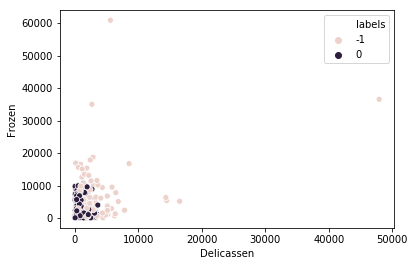

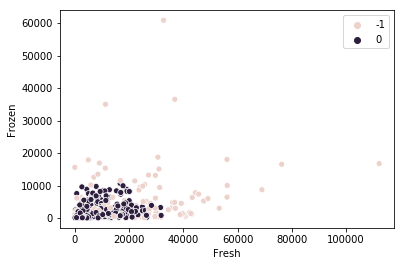

In [114]:
sns.scatterplot(df.Delicassen, df.Frozen, hue=df.labels)
plt.show()

sns.scatterplot(df.Fresh, df.Frozen, hue = labels)
plt.show()

Text(0.5, 0, 'Delicassen')

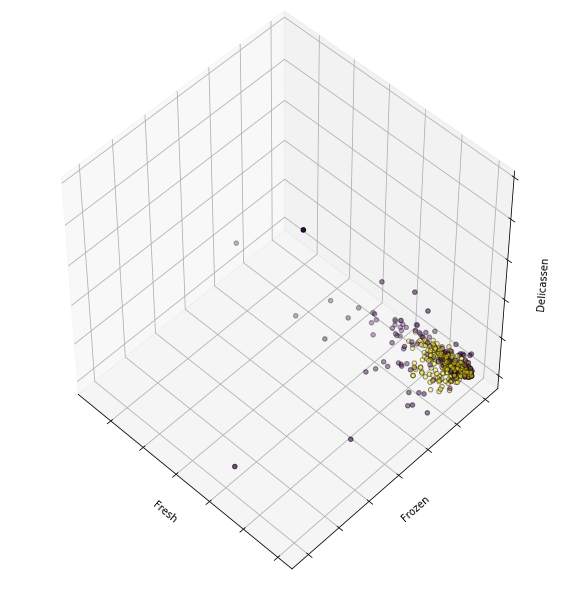

In [115]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(1, figsize=(8, 8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

# plot the points
ax.scatter(df.Fresh, df.Frozen, df.Delicassen,
           c=df.labels, edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

ax.set_xlabel('Fresh')
ax.set_ylabel('Frozen')
ax.set_zlabel('Delicassen')

# Clustering - DBSCAN - Titanic

In [189]:
import acquire

In [190]:
df = acquire.get_titanic_data()

In [191]:
df.head()

,passenger_id,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,deck,embark_town,alone
0,0,0,3,male,22.0,1,0,7.2500,S,Third,None,Southampton,0
1,1,1,1,female,38.0,1,0,71.2833,C,First,C,Cherbourg,0
2,2,1,3,female,26.0,0,0,7.9250,S,Third,None,Southampton,1
3,3,1,1,female,35.0,1,0,53.1000,S,First,C,Southampton,0
4,4,0,3,male,35.0,0,0,8.0500,S,Third,None,Southampton,1


In [192]:
df = acquire.prep_titanic(df)

In [193]:
df.head()

,passenger_id,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,embark_town,alone,embarked_encode
0,0,0,3,male,22.0,1,0,7.2500,S,Third,Southampton,0,3
1,1,1,1,female,38.0,1,0,71.2833,C,First,Cherbourg,0,0
2,2,1,3,female,26.0,0,0,7.9250,S,Third,Southampton,1,3
3,3,1,1,female,35.0,1,0,53.1000,S,First,Southampton,0,3
4,4,0,3,male,35.0,0,0,8.0500,S,Third,Southampton,1,3


In [194]:
df = df.drop(['embark_town', 'class', 'sex', 'embarked','passenger_id', 'embarked_encode', 'parch','sibsp','alone','pclass'], axis=1)

In [195]:
df.head()

,survived,age,fare
0,0,22.0,7.2500
1,1,38.0,71.2833
2,1,26.0,7.9250
3,1,35.0,53.1000
4,0,35.0,8.0500


In [196]:
df = df.dropna()

In [197]:
df.head()

,survived,age,fare
0,0,22.0,7.2500
1,1,38.0,71.2833
2,1,26.0,7.9250
3,1,35.0,53.1000
4,0,35.0,8.0500


In [198]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 714 entries, 0 to 890
Data columns (total 3 columns):
survived    714 non-null int64
age         714 non-null float64
fare        714 non-null float64
dtypes: float64(2), int64(1)
memory usage: 22.3 KB


In [199]:
np_array = df.values.astype('float32', copy=False)
np_array[0:10]

array([[ 0.    , 22.    ,  7.25  ],
       [ 1.    , 38.    , 71.2833],
       [ 1.    , 26.    ,  7.925 ],
       [ 1.    , 35.    , 53.1   ],
       [ 0.    , 35.    ,  8.05  ],
       [ 0.    , 54.    , 51.8625],
       [ 0.    ,  2.    , 21.075 ],
       [ 1.    , 27.    , 11.1333],
       [ 1.    , 14.    , 30.0708],
       [ 1.    ,  4.    , 16.7   ]], dtype=float32)

In [200]:
stscaler = StandardScaler().fit(np_array)
np_array = stscaler.transform(np_array)
np_array[0:10]

array([[-0.8270201 , -0.5303767 , -0.5189779 ],
       [ 1.2091604 ,  0.571831  ,  0.6918968 ],
       [ 1.2091604 , -0.25482473, -0.50621355],
       [ 1.2091604 ,  0.36516708,  0.34804913],
       [-0.8270201 ,  0.36516708, -0.5038498 ],
       [-0.8270201 ,  1.6740386 ,  0.32464793],
       [-0.8270201 , -1.9081362 , -0.25754604],
       [ 1.2091604 , -0.18593675, -0.44554436],
       [ 1.2091604 , -1.0814805 , -0.08743477],
       [ 1.2091604 , -1.7703602 , -0.3402776 ]], dtype=float32)

In [245]:
dbsc = DBSCAN(eps = .75, min_samples = 20).fit(np_array)

In [246]:
labels = dbsc.labels_
labels[0:10]

array([0, 1, 1, 1, 0, 0, 0, 1, 1, 1])

In [247]:
df['labels'] = labels
df.labels.value_counts()

 0    411
 1    265
-1     38
Name: labels, dtype: int64

In [248]:
df[df.labels==-1].head()

,survived,age,fare,labels
27,0,19.0,263.0000,-1
88,1,23.0,263.0000,-1
118,0,24.0,247.5208,-1
195,1,58.0,146.5208,-1
258,1,35.0,512.3292,-1


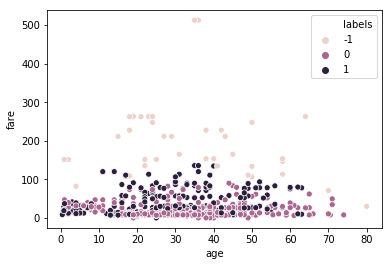

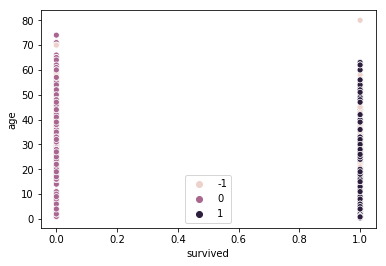

In [249]:
sns.scatterplot(df.age, df.fare, hue=df.labels)
plt.show()

sns.scatterplot(df.survived, df.age, hue=labels)
plt.show()

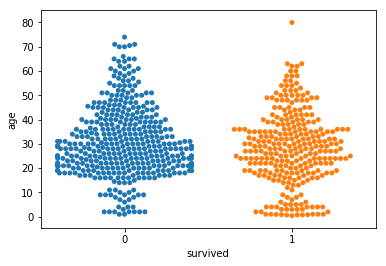

In [251]:
sns.swarmplot(x='survived', y='age', data=df)

# Clustering - DBSCAN - Iris

In [134]:
df = acquire.get_iris_data()

In [135]:
df.head()

,species_name,measurement_id,sepal_length,sepal_width,petal_length,petal_width,species_id
0,setosa,1,5.1,3.5,1.4,0.2,1
1,setosa,2,4.9,3.0,1.4,0.2,1
2,setosa,3,4.7,3.2,1.3,0.2,1
3,setosa,4,4.6,3.1,1.5,0.2,1
4,setosa,5,5.0,3.6,1.4,0.2,1


In [136]:
df = acquire.prep_iris(df)

In [137]:
df.head()

,species,sepal_length,sepal_width,petal_length,petal_width,species_encode
0,setosa,5.1,3.5,1.4,0.2,0
1,setosa,4.9,3.0,1.4,0.2,0
2,setosa,4.7,3.2,1.3,0.2,0
3,setosa,4.6,3.1,1.5,0.2,0
4,setosa,5.0,3.6,1.4,0.2,0


In [138]:
df = df[['sepal_length','sepal_width']]

In [139]:
df.head()

,sepal_length,sepal_width
0,5.1,3.5
1,4.9,3.0
2,4.7,3.2
3,4.6,3.1
4,5.0,3.6


In [140]:
np_array = df.values.astype('float32', copy=False)
np_array[0:10]

array([[5.1, 3.5],
       [4.9, 3. ],
       [4.7, 3.2],
       [4.6, 3.1],
       [5. , 3.6],
       [5.4, 3.9],
       [4.6, 3.4],
       [5. , 3.4],
       [4.4, 2.9],
       [4.9, 3.1]], dtype=float32)

In [141]:
stscaler = StandardScaler().fit(np_array)
np_array = stscaler.transform(np_array)
np_array[0:10]

array([[-0.90068126,  1.0190042 ],
       [-1.1430167 , -0.13197955],
       [-1.3853528 ,  0.32841402],
       [-1.5065206 ,  0.09821697],
       [-1.021849  ,  1.2492008 ],
       [-0.53717744,  1.9397914 ],
       [-1.5065206 ,  0.78880763],
       [-1.021849  ,  0.78880763],
       [-1.7488562 , -0.36217612],
       [-1.1430167 ,  0.09821697]], dtype=float32)

In [142]:
dbsc = DBSCAN(eps=.75, min_samples=10).fit(np_array)

In [143]:
labels = dbsc.labels_
labels[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [144]:
df['labels'] = labels
df.labels.value_counts()

 0    143
-1      7
Name: labels, dtype: int64

In [145]:
df[df.labels==-1].head()

,sepal_length,sepal_width,labels
15,5.7,4.4,-1
41,4.5,2.3,-1
60,5.0,2.0,-1
109,7.2,3.6,-1
117,7.7,3.8,-1


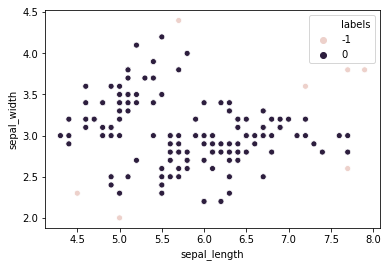

In [146]:
sns.scatterplot(df.sepal_length, df.sepal_width, hue=df.labels)
plt.show()